In [37]:
import datetime
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras
import sklearn
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import sys
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Activation, TimeDistributed, Dropout, Lambda, RepeatVector, Input, Reshape, Concatenate, Dot
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
#from keras.utils import plot_model


In [25]:
!pip install statsmodels

In [83]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 17.0 MB/s 
     |████████████████████████████████| 9.8 MB 49.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/NN_final_project/stock/'

Mounted at /content/drive


In [3]:
tickers = ['SPY','QQQ','AMZN','IWM','AAPL','AMGN','CVX','DE','JNJ','KO','OXY','WMT']
ticker = 'AMZN'

#### 1. Data preparation
The following function performs data preprocessing for the deep learning model. It requires three inputs.

Data: the information of stock we have.
time_step (n): the size of the input of the lstm model. The lstm will require stock prices n days piror to make an output.
output (m): the lstm will generate m-days ahead forcast of this particular company.

In [4]:
filename = ticker+'_train.csv'

train = pd.read_csv(path+filename)

filename = ticker+'_val.csv'

val = pd.read_csv(path+filename)

filename = ticker+'_test.csv'

test = pd.read_csv(path+filename)

In [104]:
y_train

array([[3.23109466e-04, 0.00000000e+00, 5.21318943e-04, ...,
        2.81837792e-03, 3.45102002e-03, 4.11352845e-03],
       [0.00000000e+00, 5.21318943e-04, 4.23571577e-04, ...,
        3.45102002e-03, 4.11352845e-03, 3.42658318e-03],
       [5.21318943e-04, 4.23571577e-04, 2.81837792e-03, ...,
        4.11352845e-03, 3.42658318e-03, 4.00220529e-03],
       ...,
       [8.56042826e-01, 8.52385459e-01, 8.55697990e-01, ...,
        8.84432973e-01, 8.82640915e-01, 8.87207900e-01],
       [8.52385459e-01, 8.55697990e-01, 8.73596634e-01, ...,
        8.82640915e-01, 8.87207900e-01, 8.96339086e-01],
       [8.55697990e-01, 8.73596634e-01, 8.84432973e-01, ...,
        8.87207900e-01, 8.96339086e-01, 9.15872285e-01]])

In [102]:
sc = MinMaxScaler(feature_range = (0, 1))
sc2 = MinMaxScaler(feature_range = (0, 1))

training_set_scaled = sc.fit_transform(train[['Volume','Adj Close','rsi','bond_yield']].values)
y_scaled = sc2.fit_transform(train['Adj Close'].values.reshape(-1,1))

time_step = 7
output = 7

def transform_data(data,time_step,output,sc,sc2):
  training_set_scaled = sc.transform(data[['Volume','Adj Close','rsi','bond_yield']].values)
  y_scaled = sc2.transform(data['Adj Close'].values.reshape(-1,1))
  n = time_step
  m = output
  num_training_samples = np.array(data).shape[0]

  X_train = []
  y_train = []
  for i in range(n, num_training_samples):
    X_train.append(training_set_scaled[i-n:i-m+1, :])
    y_train.append(training_set_scaled[i-m+1:i+1, 1])
    
  X_train, y_train = np.array(X_train), np.array(y_train)
  #y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

  print("the shape of X:", X_train.shape)
  print("the shape of y:", y_train.shape)

  return X_train,y_train

In [103]:
X_train,y_train = transform_data(train,time_step,output,sc,sc2)
X_val,y_val = transform_data(val,time_step,output,sc,sc2)
X_test,y_test = transform_data(test,time_step,output,sc,sc2)

the shape of X: (3163, 1, 4)
the shape of y: (3163, 7)
the shape of X: (63, 1, 4)
the shape of y: (63, 7)
the shape of X: (41, 1, 4)
the shape of y: (41, 7)


In [100]:
X_train.shape

(3163, 1, 4)

#### 2. LSTM

In [125]:
n = time_step
m = output

model = Sequential()
model.add(LSTM(units = 512, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 32))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = m))

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, 
                               patience = 10,
                               restore_best_weights = False
                               )

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32,callbacks = [early_stopping],validation_data=(X_val, y_val))

Epoch 1/100
99/99 [==============================] - 14s 59ms/step - loss: 0.0517 - val_loss: 0.0042
Epoch 2/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0048 - val_loss: 9.0107e-04
Epoch 3/100
99/99 [==============================] - 4s 39ms/step - loss: 0.0037 - val_loss: 0.0052
Epoch 4/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 5/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 6/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 7/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0023 - val_loss: 6.0138e-04
Epoch 8/100
99/99 [==============================] - 4s 39ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 10/100
99/99 [==============================] - 4s 38ms/step - loss: 0.0019 - val_los

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 512)            1058816   
                                                                 
 dropout_5 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 256)            787456    
                                                                 
 dropout_6 (Dropout)         (None, 1, 256)            0         
                                                                 
 lstm_9 (LSTM)               (None, 1, 128)            197120    
                                                                 
 dropout_7 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_10 (LSTM)              (None, 1, 64)            

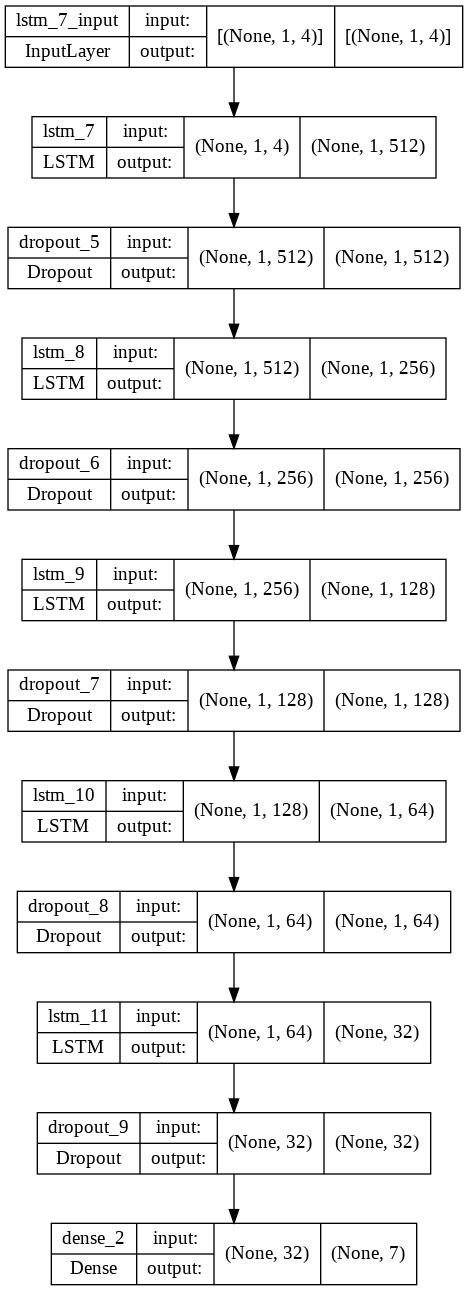

In [126]:
#Evaluate performance 
model.summary()

#model.save("model_lstm_layer2.h5")
#print("Model saved.")

loss = model.evaluate(X_test, y_test, batch_size = 32)

# early_stopping.stopped_epoch returns 0 if training didn't stop early. 
print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

tf.keras.utils.plot_model(model, show_shapes=True)



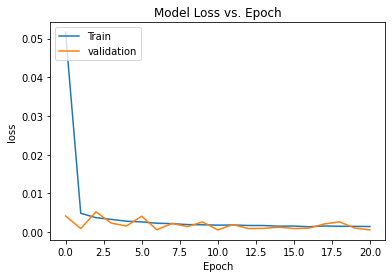

In [127]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [128]:
test_index = test['Date']

def evaluate_model(X_test,m):
  predicted_stock_price = model.predict(X_test)
  for i in range(m):
    
    title = ticker + ' Stock Price Prediction'
    y_test_i = sc2.inverse_transform(y_test[:,i,0].reshape(-1,1))
    dayi = sc2.inverse_transform(predicted_stock_price[:,i].reshape(-1,1))

    plot_d = {'actual price': y_test_i.reshape(-1,), 'pred_lstm': dayi.reshape(-1,)}
    plot_df = pd.DataFrame(plot_d)
    plot_df.index = test_index[m:]

    mse = sklearn.metrics.mean_squared_error(y_test_i, dayi)
    rmse = math.sqrt(mse)
    print("rmse of day ", i+1, " forecast is : ", rmse)
    # Visualising the results
    #plt.plot(dataset_test.index,y_test_i, color = 'red', label = 'Real Stock Price')
    #plt.plot(dataset_test.index,y_test_i, color = 'red', label = 'Real Stock Price')
    rcParams['figure.figsize'] = (15,5)
    plt.plot(plot_df['actual price'], color = 'red', label = 'Real Stock Price')
    #plt.plot(dataset_test.index,dayi, color = 'blue', label = 'Predicted Stock Price')
    plt.plot(plot_df['pred_lstm'], color = 'blue', label = 'Predicted Stock Price')
    #plt.xticks(np.arange(0,num_test_samples,400))
    plt.title(title)
    plt.xlabel('Time')
    ylab = ticker + ' Stock Price'
    plt.ylabel(ylab)
    plt.legend()
    plt.show()

    if i == 0:
      y_actual = y_test_i
      y_pred = dayi
    
  return y_actual,y_pred

In [129]:
y_actual,y_pred = evaluate_model(X_test,m)

d = {'time':test_index[m:],'actual price': y_actual.reshape(-1,), 'pred_lstm': y_pred.reshape(-1,)}
df = pd.DataFrame(d)
df

IndexError: ignored

#### 3. Autoencoder

In [13]:
def seq2seq(feature_len=1,after_day=5, time_step = 60):
    '''
    Encoder:
    X = Input sequence
    C = LSTM(X); The context vector
    Decoder:
    y(t) = LSTM(s(t-1), y(t-1)); where s is the hidden state of the LSTM(h and c)
    y(0) = LSTM(s0, C); C is the context vector from the encoder.
    '''
    
    time_step = time_step - after_day + 1
    input_shape = (time_step,feature_len)

    # Encoder
    #encoder_inputs = Input(shape=input_shape) # (timesteps, feature)
    #encoder = LSTM(units=100, return_state=True,  name='encoder')
    #encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    #states = [state_h, state_c]

    #Encoder Multiple layers
    encoder_inputs=Input(shape=input_shape) # (timesteps, feature)
    encoder_lstm=LSTM(units=100, return_state=True,return_sequences=True)(encoder_inputs)
    encoder_lstm=LSTM(units=100, return_state=True)(encoder_lstm)
    encoder_outputs, state_h, state_c=encoder_lstm
    states = [state_h, state_c]

    # Decoder
    reshapor = Reshape((1, 100), name='reshapor')
    decoder = LSTM(units=100, return_sequences=True, return_state=True, name='decoder')

    # Densor
    #tdensor = TimeDistributed(Dense(units=200, activation='linear', name='time_densor'))
    densor_output = Dense(units=1, activation='linear', name='output')
    

    inputs = reshapor(encoder_outputs)
    #inputs = tdensor(inputs)
    all_outputs = []

    for _ in range(after_day):
        outputs, h, c = decoder(inputs, initial_state=states)

        #inputs = tdensor(outputs)
        inputs = outputs
        states = [state_h, state_c]

        outputs = densor_output(outputs)
        all_outputs.append(outputs)

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

    return model

In [14]:
batch_size = 32
after_day = m
time_step = n

model = seq2seq(feature_len=4,after_day=after_day, time_step = time_step)


early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, 
                               patience = 9,
                               restore_best_weights = False
                               )

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, epochs = 100, batch_size = batch_size,callbacks = [early_stopping],validation_data=(X_val, y_val))

Epoch 1/100
99/99 [==============================] - 22s 55ms/step - loss: 0.0160 - val_loss: 0.0011
Epoch 2/100
99/99 [==============================] - 2s 18ms/step - loss: 2.9683e-04 - val_loss: 0.0010
Epoch 3/100
99/99 [==============================] - 2s 18ms/step - loss: 2.0375e-04 - val_loss: 0.0017
Epoch 4/100
99/99 [==============================] - 2s 18ms/step - loss: 2.0618e-04 - val_loss: 6.5825e-04
Epoch 5/100
99/99 [==============================] - 2s 19ms/step - loss: 1.9601e-04 - val_loss: 6.4977e-04
Epoch 6/100
99/99 [==============================] - 2s 18ms/step - loss: 1.9721e-04 - val_loss: 6.3913e-04
Epoch 7/100
99/99 [==============================] - 2s 18ms/step - loss: 1.9593e-04 - val_loss: 7.7570e-04
Epoch 8/100
99/99 [==============================] - 2s 18ms/step - loss: 2.0605e-04 - val_loss: 6.1993e-04
Epoch 9/100
99/99 [==============================] - 2s 18ms/step - loss: 2.1931e-04 - val_loss: 8.7334e-04
Epoch 10/100
99/99 [=======================

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 4)]       0           []                               
                                                                                                  
 lstm_5 (LSTM)                  [(None, 1, 100),     42000       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_6 (LSTM)                  [(None, 100),        80400       ['lstm_5[0][0]',                 
                                 (None, 100),                     'lstm_5[0][1]',             

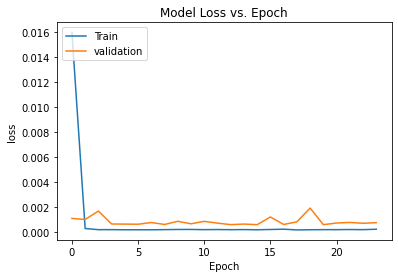

rmse of day  1  forecast is :  106.6166346994726


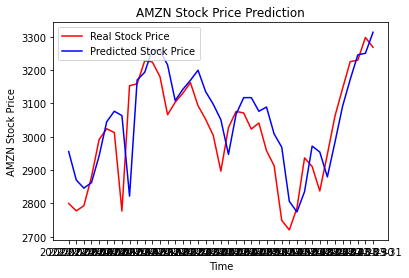

rmse of day  2  forecast is :  135.17608795848557


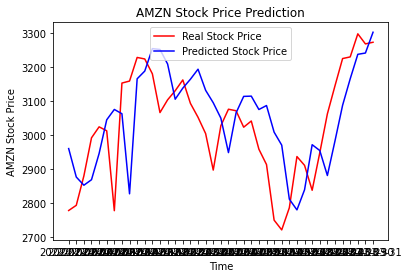

rmse of day  3  forecast is :  158.3045170273012


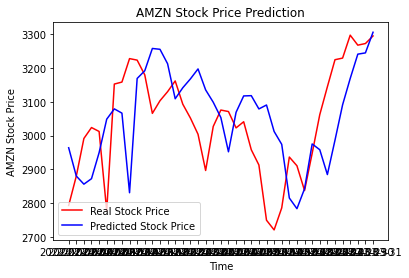

rmse of day  4  forecast is :  168.74472024895294


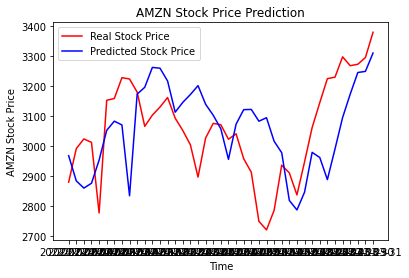

rmse of day  5  forecast is :  181.76059233836384


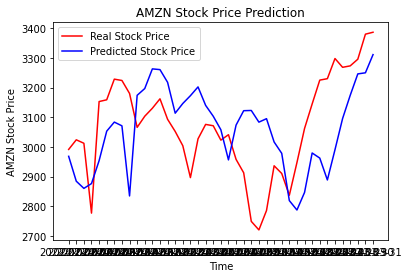

rmse of day  6  forecast is :  195.72641228827842


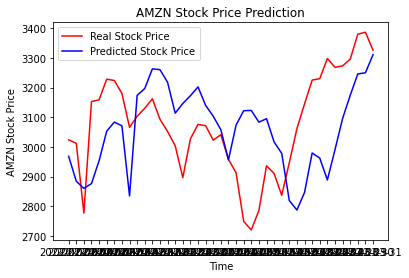

rmse of day  7  forecast is :  215.93714382997203


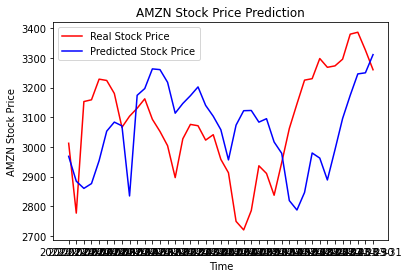

,time,actual price,pred_lstm
7,2022-02-02,2799.719971,2955.432373
8,2022-02-03,2777.449951,2869.984375
9,2022-02-04,2792.750000,2845.604736
10,2022-02-07,2879.560059,2862.243896
11,2022-02-08,2991.469971,2942.198242
12,2022-02-09,3023.870117,3044.779297
13,2022-02-10,3012.250000,3076.325439
14,2022-02-11,2776.909912,3063.239502
15,2022-02-14,3152.790039,2821.761719
16,2022-02-15,3158.709961,3170.143311


In [15]:
#Evaluate performance 
model.summary()

#model.save("model_lstm_layer2.h5")
#print("Model saved.")

loss = model.evaluate(X_test, y_test, batch_size = 32)

# early_stopping.stopped_epoch returns 0 if training didn't stop early. 
print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

tf.keras.utils.plot_model(model, show_shapes=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

y_actual,y_pred = evaluate_model(X_test,m)

d = {'time':test_index[m:],'actual price': y_actual.reshape(-1,), 'pred_lstm': y_pred.reshape(-1,)}
df = pd.DataFrame(d)
df

#### 4. Autoencoder with attention

In [16]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')


def one_step_attention(a, s_prev, repeator, concatenator, densor, activator, dotor):
    s_prev = repeator(s_prev)
    concat = concatenator([s_prev, a])
    e = densor(concat)
    alphas = activator(e)
    context =  dotor([alphas, a])

    return context

def seq2seq_attention(feature_len=1, after_day=1, time_step=20):

    time_step = time_step-after_day+1
    input_shape = (time_step,feature_len)
    # Define the inputs of your model with a shape (Tx, feature)
    X = Input(shape=input_shape)

    # Initialize empty list of outputs
    all_outputs = []

    # Encoder: pre-attention LSTM
    encoder = LSTM(units=100, return_state=True, return_sequences=True, name='encoder')
    # Decoder: post-attention LSTM
    decoder = LSTM(units=100, return_state=True, name='decoder')
    # Output
    decoder_output = Dense(units=1, activation='linear', name='output')
    model_output = Reshape((1, 1))

    # Attention
    repeator = RepeatVector(time_step)
    concatenator = Concatenate(axis=-1)
    densor = Dense(1, activation = "relu")
    activator = Activation(softmax, name='attention_weights')
    dotor =  Dot(axes = 1)

    encoder_outputs, s, c = encoder(X)

    for t in range(after_day):
        context = one_step_attention(encoder_outputs, s, repeator, concatenator, densor, activator, dotor)

        a, s, c = decoder(context, initial_state=[s, c])

        outputs = decoder_output(a)
        outputs = model_output(outputs)
        all_outputs.append(outputs)

    all_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=X, outputs=all_outputs)

    return model

batch_size = 32

model = seq2seq_attention(feature_len=4, after_day=after_day, time_step=time_step)

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               verbose = 1, 
                               patience = 9,
                               restore_best_weights = False
                               )

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, epochs = 100, batch_size = batch_size,callbacks = [early_stopping],validation_data=(X_val, y_val))

Epoch 1/100
99/99 [==============================] - 33s 53ms/step - loss: 0.0159 - val_loss: 0.0090
Epoch 2/100
99/99 [==============================] - 2s 18ms/step - loss: 8.1588e-04 - val_loss: 0.0017
Epoch 3/100
99/99 [==============================] - 2s 18ms/step - loss: 3.4492e-04 - val_loss: 0.0012
Epoch 4/100
99/99 [==============================] - 2s 18ms/step - loss: 2.6156e-04 - val_loss: 9.4220e-04
Epoch 5/100
99/99 [==============================] - 2s 18ms/step - loss: 2.5967e-04 - val_loss: 7.9463e-04
Epoch 6/100
99/99 [==============================] - 2s 18ms/step - loss: 2.2340e-04 - val_loss: 7.5887e-04
Epoch 7/100
99/99 [==============================] - 2s 18ms/step - loss: 2.3169e-04 - val_loss: 0.0010
Epoch 8/100
99/99 [==============================] - 2s 18ms/step - loss: 2.3743e-04 - val_loss: 0.0010
Epoch 9/100
99/99 [==============================] - 2s 18ms/step - loss: 2.2539e-04 - val_loss: 8.3155e-04
Epoch 10/100
99/99 [==============================]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 4)]       0           []                               
                                                                                                  
 encoder (LSTM)                 [(None, 1, 100),     42000       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 1, 100)       0           ['encoder[0][1]',                
                                                                  'decoder[0][1]',          

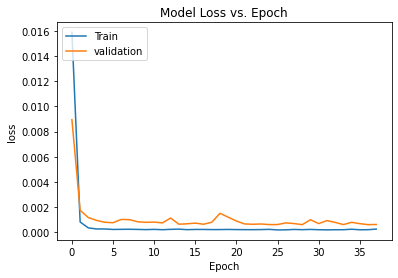

rmse of day  1  forecast is :  102.54083713813225


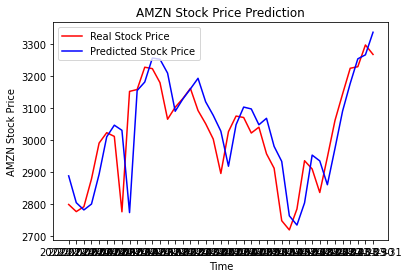

rmse of day  2  forecast is :  134.22635431433864


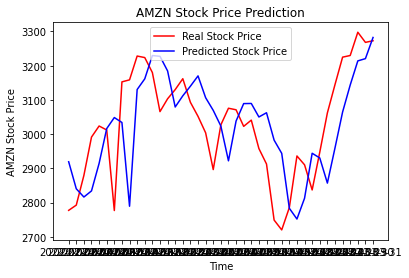

rmse of day  3  forecast is :  159.29164100543173


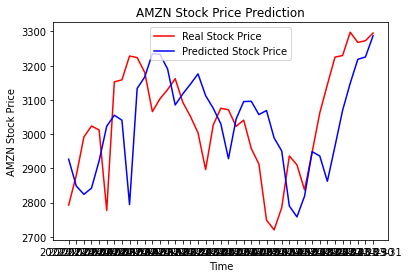

rmse of day  4  forecast is :  171.09110691867846


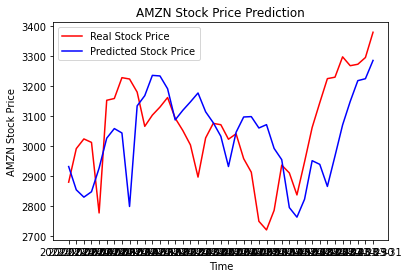

rmse of day  5  forecast is :  184.47742831107888


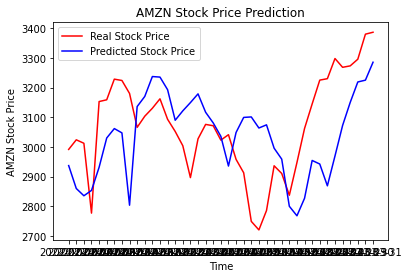

rmse of day  6  forecast is :  198.14220454988765


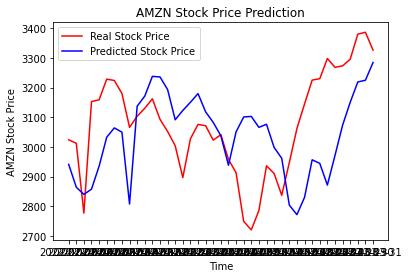

rmse of day  7  forecast is :  217.78679724552597


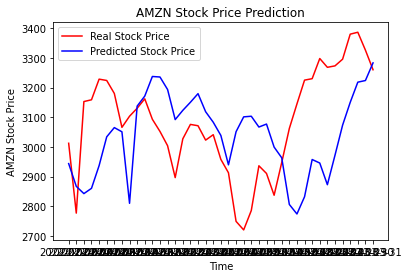

,time,actual price,pred_lstm
7,2022-02-02,2799.719971,2889.025146
8,2022-02-03,2777.449951,2805.291016
9,2022-02-04,2792.750000,2782.695557
10,2022-02-07,2879.560059,2801.106445
11,2022-02-08,2991.469971,2894.119385
12,2022-02-09,3023.870117,3010.937744
13,2022-02-10,3012.250000,3047.284912
14,2022-02-11,2776.909912,3031.270996
15,2022-02-14,3152.790039,2774.399658
16,2022-02-15,3158.709961,3155.475342


In [17]:
#Evaluate performance 
model.summary()

#model.save("model_lstm_layer2.h5")
#print("Model saved.")

loss = model.evaluate(X_test, y_test, batch_size = 32)

# early_stopping.stopped_epoch returns 0 if training didn't stop early. 
print('Training stopped after',early_stopping.stopped_epoch,'epochs.')

tf.keras.utils.plot_model(model, show_shapes=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

y_actual,y_pred = evaluate_model(X_test,m)

d = {'time':test_index[m:],'actual price': y_actual.reshape(-1,), 'pred_lstm': y_pred.reshape(-1,)}
df = pd.DataFrame(d)
df

#### 5. ARIMA


In [47]:
res = sm.tsa.arma_order_select_ic(y_train[:,0,0], ic='aic', trend='nc')
res

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



{'aic':               0             1             2
 0           NaN  -1904.244174  -5573.286516
 1 -22426.437557 -22445.548399 -22443.630905
 2 -22435.899862 -22447.166233 -22448.142820
 3 -22443.835943 -22449.344870 -22480.906871
 4 -22456.297890 -22442.650664 -22473.180287, 'aic_min_order': (3, 2)}

In [48]:
res

{'aic':               0             1             2
 0           NaN  -1904.244174  -5573.286516
 1 -22426.437557 -22445.548399 -22443.630905
 2 -22435.899862 -22447.166233 -22448.142820
 3 -22443.835943 -22449.344870 -22480.906871
 4 -22456.297890 -22442.650664 -22473.180287, 'aic_min_order': (3, 2)}

In [39]:
#from plotly.offline import init_notebook_mode, iplot, iplot_mpl
x=X_train[:,0,0]
#iplot([Scatter(x=X_train['Date'], y=y_train)])
X_train

array([[[8.55384026e-02, 5.94629468e-04, 2.86637430e-01, 6.07439199e-01]],

       [[1.09263468e-01, 3.23109466e-04, 2.43645404e-01, 6.13447756e-01]],

       [[1.36821392e-01, 0.00000000e+00, 1.96225736e-01, 5.77968547e-01]],

       ...,

       [[4.36503583e-02, 8.67104548e-01, 9.71771602e-02, 2.17167386e-01]],

       [[3.34874487e-02, 8.56042826e-01, 5.75417715e-02, 2.21459228e-01]],

       [[5.05289554e-02, 8.52385459e-01, 4.50307093e-02, 2.12589408e-01]]])

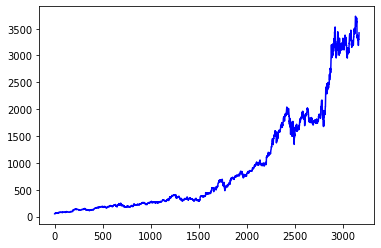

In [116]:
#plot scaled data
plt.plot(train['Adj Close'], color="blue")


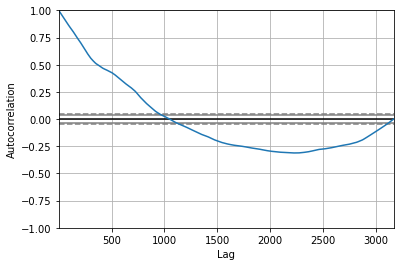

In [81]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train['Adj Close'])

In [85]:
#auto arima
import pmdarima as pm
model = pm.auto_arima(train['Adj Close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29552.110, Time=2.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29555.985, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29554.350, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29554.390, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29559.439, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29553.643, Time=5.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29553.531, Time=4.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=29556.345, Time=1.84 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=29556.182, Time=0.76 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29550.196, Time=8.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=29532.847, Time=5.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29543.549, Time=4.99 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=29529.814, Time=5.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=29532.423, Time=6.95 sec
 ARIMA(3,1,3)(0,0,0

In [118]:
model = ARIMA(train['Adj Close'], order=(3,1,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 3169
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -14756.680
Method:                       css-mle   S.D. of innovations             25.473
Date:                Sat, 30 Apr 2022   AIC                          29529.359
Time:                        00:48:51   BIC                          29577.848
Sample:                             1   HQIC                         29546.752
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0577      0.358      2.951      0.003       0.355       1.760
ar.L1.D.Adj Close    -0.4745      0.090     -5.285      0.000      -0.651      -0.299
ar.L2.D.Adj Close     0.

In [120]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
                        
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  
            'corr':corr, 'minmax':minmax})

fc, se, conf = model_fit.forecast(48, alpha=0.05)
forecast_accuracy(fc, test['Adj Close'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



{'corr': 0.457452902431103,
 'mae': 377.59765296991094,
 'mape': 0.12741511309216194,
 'me': 377.59765296991094,
 'minmax': 0.1101413054953162,
 'mpe': 0.12741511309216194,
 'rmse': 415.01918261780423}

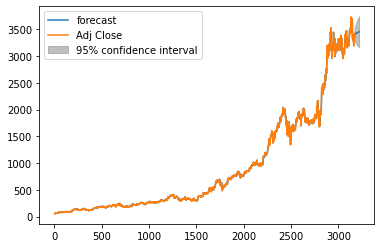

In [124]:
#model_fit.plot_predict(start=2, end=len(df)+12)
#plt.show()
model_fit.plot_predict(start=2, end=len(train)+48)
plt.show()

#### 6. Machine learning methods

#### 7. Model performance comparison

The Relative Strength Index, or RSI, is used to locate overbought and oversold conditions in financial markets. As an oscillator type indicator it does this by moving up and down within a range of 0 to 100, with 0 representing the most oversold conditions, and 100 representing the most overbought conditions. Typically any reading above 70 is considered overbought and ripe for a reversal, while readings below 30 are considered oversold and also ripe for a reversal. Some traders use the 80 and 20 levels as their signal points.

In [72]:
y_train[:,0,0]

array([3.23109466e-04, 0.00000000e+00, 5.21318943e-04, ...,
       8.56042826e-01, 8.52385459e-01, 8.55697990e-01])